**Reference**: Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder

This file trains an autoencoder with the instances of the normal digit in the training data. 

Then, it measures the reconstruction loss for the digits in the test data.

The reconstruction loss for the instances of the abnormal digit in the test data is higher.

A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution).  

Then, if the reconstruction loss of a digit in the test data is higher than this threshold, it is classified as abnormal.

By comparing with the known labels of test data (with T for normal digit(s) and F for abnormal digit(s)), the confusion matrix and the accuracy is calculated. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import mnist
from keras.models import Model
# import cv2

**Loading the MNIST data and forming arrays of the normal training data and the test data (normal and abnormal)**

In [2]:
# nl = [0, 1, 2, 3, 4, 5, 6, 7, 9]  # normal digits
abn = 8      # abnormal digit

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

normal_data = x_train[y_train != abn]                   # Normal training data (Normal digits)
normal_labels = y_train[y_train != abn]

test_data = x_test                           # Test data (both normal digits and the abnormal digit)
test_labels = y_test

test_labels_T_F = np.where(test_labels != abn, True, False)
# Array of T and F, T where test digits are normal and F where test digits are abnormal

In [3]:
normal_data.shape, test_data.shape, test_labels.shape

((54149, 28, 28), (10000, 28, 28), (10000,))

In [4]:
normal_test_data = test_data[test_labels != abn]                # The normal digits in the test data
abnormal_test_data = test_data[test_labels == abn]              # The abnormal digit in the test data
normal_test_labels = test_labels[test_labels != abn]            # Their labels
abnormal_test_labels = test_labels[test_labels == abn]          # Their labels

In [5]:
normal_test_data.shape, abnormal_test_data.shape

((9026, 28, 28), (974, 28, 28))

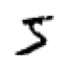

In [6]:
# First normal digit
plt.figure(figsize=(1,1))
plt.imshow(normal_data[0], cmap="binary")
plt.axis('off')
plt.show()

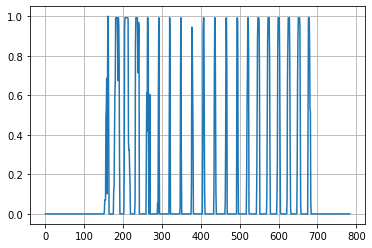

In [7]:
# 1 dim plot of (flattened array of) first normal digit
plt.grid()
plt.plot(np.arange(28*28), normal_data[0].ravel())
plt.show()

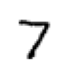

In [8]:
# first test digit
plt.figure(figsize=(1,1))
plt.imshow(test_data[0], cmap="binary")
plt.axis('off')
plt.show()

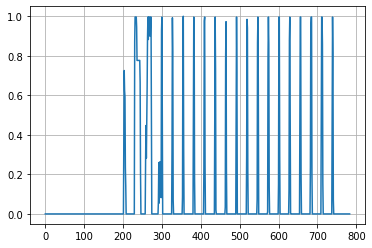

In [9]:
# 1 dim plot of first test digit
plt.grid()
plt.plot(np.arange(28*28), test_data[0].ravel())
plt.show()

In [10]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(256, activation="selu"),
      layers.Dense(128, activation="selu"),
      layers.Dense(64, activation="selu"),
      layers.Dense(16, activation="selu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="selu"),
      layers.Dense(128, activation="selu"),
      layers.Dense(256, activation="selu"),
      layers.Dense(28*28, activation="sigmoid"),
      layers.Reshape((28, 28))])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [11]:
# autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [12]:
history = autoencoder.fit(normal_data, normal_data, 
          epochs=100, 
          batch_size=128,
          validation_data=(normal_test_data, normal_test_data),
          shuffle=True)

Epoch 1/100
424/424 [==============================] - 8s 12ms/step - loss: 0.1774 - val_loss: 0.1487
Epoch 2/100
424/424 [==============================] - 5s 12ms/step - loss: 0.1268 - val_loss: 0.1251
Epoch 3/100
424/424 [==============================] - 4s 10ms/step - loss: 0.1159 - val_loss: 0.1186
Epoch 4/100
424/424 [==============================] - 5s 11ms/step - loss: 0.1099 - val_loss: 0.1154
Epoch 5/100
424/424 [==============================] - 4s 8ms/step - loss: 0.1059 - val_loss: 0.1084
Epoch 6/100
424/424 [==============================] - 3s 7ms/step - loss: 0.1032 - val_loss: 0.1106
Epoch 7/100
424/424 [==============================] - 3s 7ms/step - loss: 0.1012 - val_loss: 0.1119
Epoch 8/100
424/424 [==============================] - 3s 7ms/step - loss: 0.0996 - val_loss: 0.1065
Epoch 9/100
424/424 [==============================] - 3s 7ms/step - loss: 0.0983 - val_loss: 0.1089
Epoch 10/100
424/424 [==============================] - 3s 7ms/step - loss: 0.0973 - va

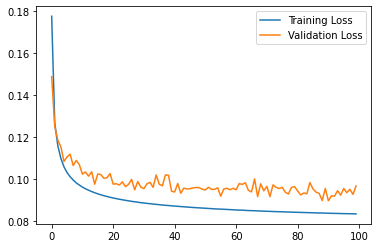

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

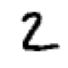

In [14]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.figure(figsize=(1,1))
plt.imshow(normal_test_data[1], cmap="binary")
plt.axis('off')
plt.show()

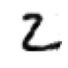

In [15]:
plt.figure(figsize=(1,1))
plt.imshow(decoded_data[1], cmap="binary")
plt.axis('off')
plt.show()

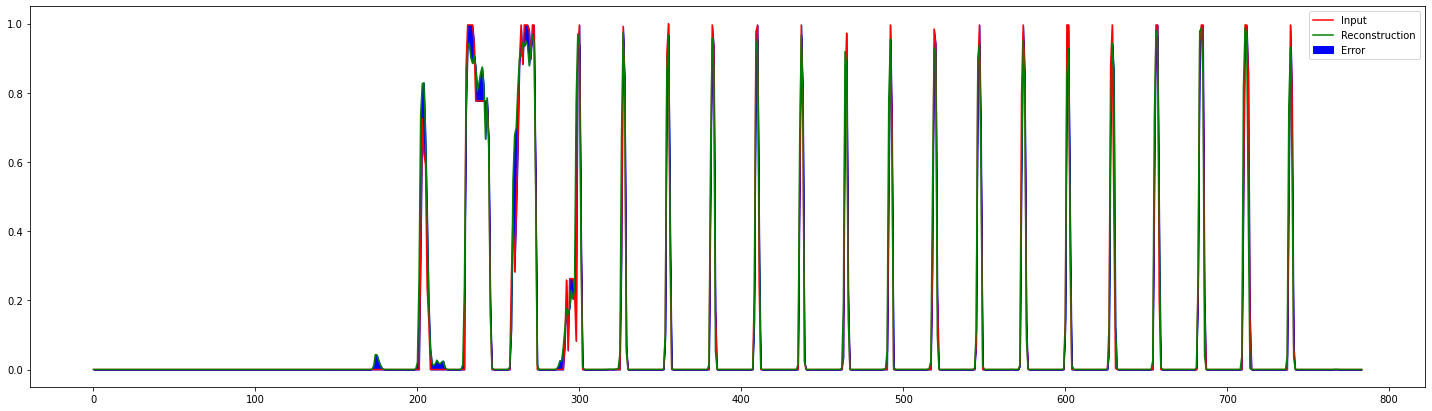

In [16]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(decoded_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_data[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

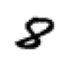

In [17]:
encoded_abn_data = autoencoder.encoder(abnormal_test_data).numpy()
decoded_abn_data = autoencoder.decoder(encoded_abn_data).numpy()

plt.figure(figsize=(1,1))
plt.imshow(abnormal_test_data[0], cmap="binary")
plt.axis('off')
plt.show()

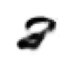

In [18]:
plt.figure(figsize=(1,1))
plt.imshow(decoded_abn_data[0], cmap="binary")
plt.axis('off')
plt.show()

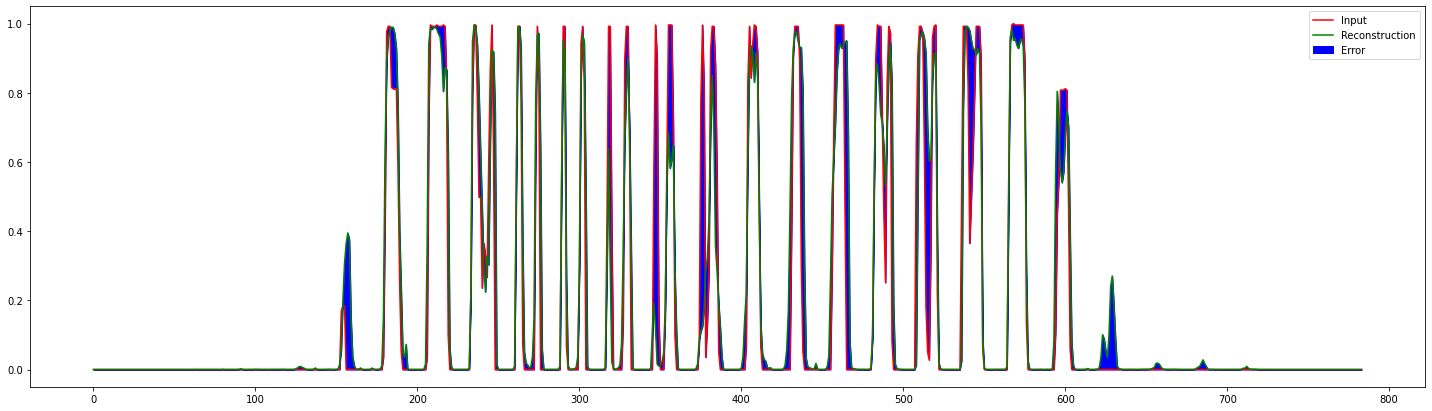

In [19]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(decoded_abn_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_abn_data[0].ravel(), abnormal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

**Distribution of the reconstruction losses of the normal training data**

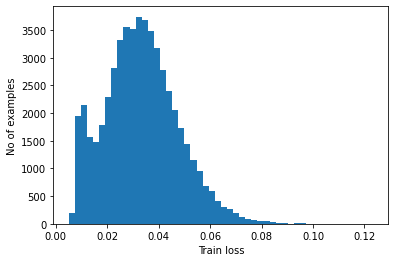

In [20]:
reconstructions = autoencoder.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), normal_data.reshape(-1, 784))
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [21]:
print("Mean: ", np.mean(train_loss))
print("Std: ", np.std(train_loss))

Mean:  0.033184778
Std:  0.01416315


In [22]:
threshold1 = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold1: ", threshold1)

Threshold1:  0.06859265407547355


**Distribution of the reconstruction losses of the abnormal test data**

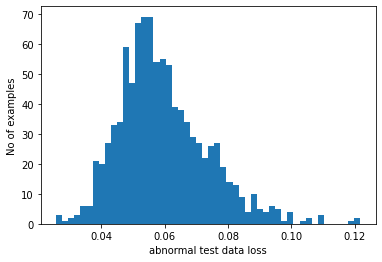

In [23]:
reconstructions = autoencoder.predict(abnormal_test_data)
abn_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_test_data.reshape(-1,784))

plt.hist(abn_test_loss[None, :], bins=50)
plt.xlabel("abnormal test data loss")
plt.ylabel("No of examples")
plt.show()

In [24]:
# threshold2 = np.mean(abn_test_loss) - np.std(abn_test_loss)
# print("Threshold2: ", threshold2)

In [25]:
np.mean(abn_test_loss) , np.std(abn_test_loss)

(0.059540395, 0.014145377)

**Threshold will be threshold1 = mean + std of the distribution of the reconstruction losses of the normal training data**

In [26]:
threshold = threshold1

**Calculation of the confusion matrix**

In [27]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [28]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             353   9647
 label: F   [[222   752]    974
        T    [131   8895]]   9026
Accuracy = 0.9117
Precision = 0.9220483051725925
Recall = 0.9854863727010857


In [29]:
print(confusion_matrix(test_labels_T_F, preds))

[[ 222  752]
 [ 131 8895]]


**Distribution of the reconstruction losses of the test data (normal and abnormal)**

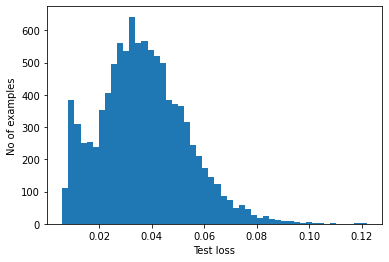

In [30]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), test_data.reshape(-1,784))

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()